In [64]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import lightgbm as lgb


In [65]:
# --- CARGA DE DATOS ---
os.chdir('C:/Users/POZOLE/Documents/pp/nohtyp/practice_algo_trading/modelos_dummys_ver2.0/data_modelos_dummys2.0')
df = pd.read_csv('modelo_supervisado_2.0.csv')
df = df.copy()  # Evitar warning de Pandas


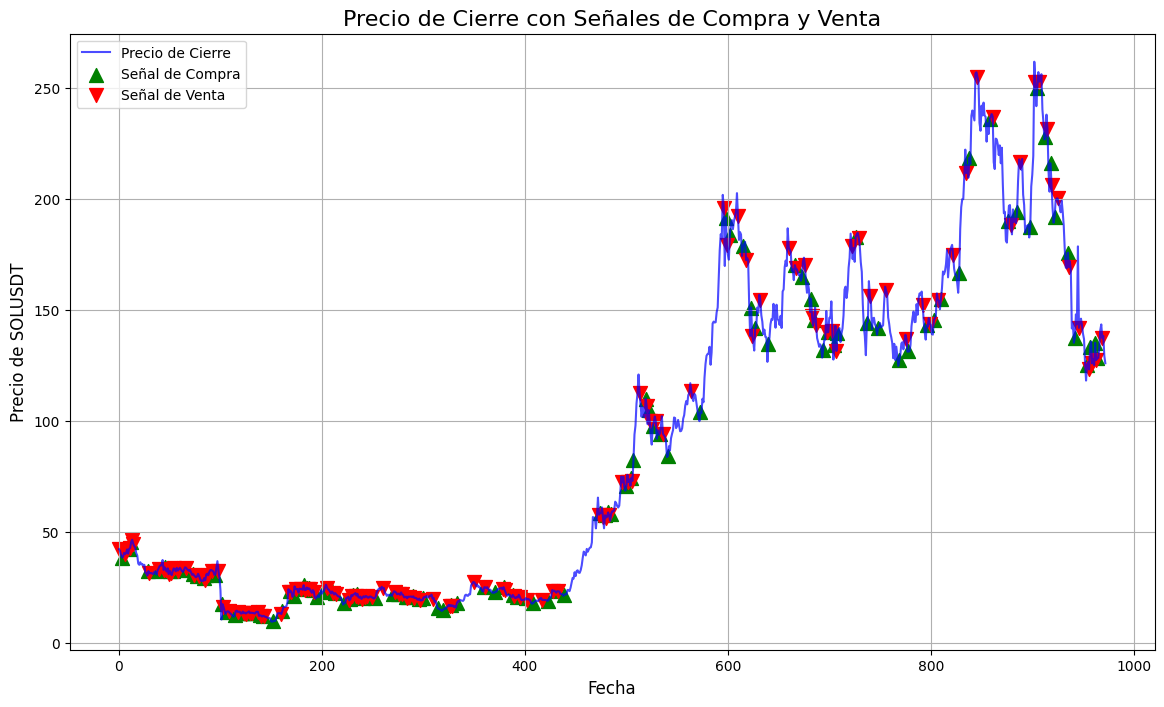

In [66]:
import matplotlib.pyplot as plt

# Crear gráfico de precios
plt.figure(figsize=(14, 8))
plt.plot(data['close'], label='Precio de Cierre', color='blue', alpha=0.7)

# Añadir señales de compra y venta
plt.scatter(data.index[data['buy_signal'] == 1], data['close'][data['buy_signal'] == 1], 
            marker='^', color='green', label='Señal de Compra', alpha=1, s=100)
plt.scatter(data.index[data['sell_signal'] == 1], data['close'][data['sell_signal'] == 1], 
            marker='v', color='red', label='Señal de Venta', alpha=1, s=100)

# Personalización del gráfico
plt.title('Precio de Cierre con Señales de Compra y Venta', fontsize=16)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel(f'Precio de {'SOLUSDT'}', fontsize=12)
plt.legend(loc='best')
plt.grid(True)

# Mostrar gráfico
plt.show()

In [67]:
# --- DEFINICIÓN DE VARIABLES ---
features = ['open', 'value', 'rsi', 'macd', 'adx', 'adp', 'adm', 'dri',
            'dlogri', 'avgtr', 'donch_hband', 'donch_lband', 'vwap']
target = 'signals'

# Verificar valores únicos en target antes de mapear
print(f"Valores únicos en 'signals': {df[target].unique()}")

# Mapear señales a valores numéricos
map_signals = {'buy': 0, 'sell': 1, 'hold': 2}
df['signals'] = df['signals'].map(map_signals)

# Verificar valores únicos después del mapeo
print(f"Valores únicos en 'signals' después del mapeo: {df['signals'].unique()}")

# Variables predictoras y objetivo
X = df[features]
y = df[target]

# --- DIVISIÓN DE DATOS Y NORMALIZACIÓN ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# --- MODELO LIGHTGBM ---
params = {
    'objective': 'multiclass',
    'num_class': 3,
    'metric': 'multi_logloss',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9
}

# Crear datasets de LightGBM
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# Entrenamiento con Early Stopping
callbacks = [lgb.early_stopping(stopping_rounds=10)]
clf = lgb.train(params, train_data, num_boost_round=100, valid_sets=[test_data], callbacks=callbacks)

# Predicciones
y_pred_prob = clf.predict(X_test, num_iteration=clf.best_iteration)
y_pred = np.argmax(y_pred_prob, axis=1)

# Evaluación del modelo
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print(classification_report(y_test, y_pred))

Valores únicos en 'signals': ['sell' 'hold' 'buy']
Valores únicos en 'signals' después del mapeo: [1 2 0]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000189 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2541
[LightGBM] [Info] Number of data points in the train set: 681, number of used features: 13
[LightGBM] [Info] Start training from score -2.080911
[LightGBM] [Info] Start training from score -2.069215
[LightGBM] [Info] Start training from score -0.289152
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM

In [ ]:
# Normalizar todo el conjunto de datos
X_scaled = scaler.transform(X)

# Hacer predicciones para todo el conjunto de datos
y_pred_prob = clf.predict(X_scaled, num_iteration=clf.best_iteration)  # Probabilidades para cada clase
df['predictions'] = np.argmax(y_pred_prob, axis=1)  # Convertir las probabilidades en clases

# Comparar las predicciones con la variable objetivo real
df[['signals', 'predictions']].head(20)  # Muestra las primeras 20 filas



,signals,predictions
0,1,2
1,2,2
2,2,2
3,0,2
4,2,2
5,2,2
6,1,2
7,2,2
8,2,2
9,2,2


In [69]:
# --- VALIDACIÓN CRUZADA ---
clf_cv = lgb.LGBMClassifier(objective='multiclass', num_class=3, boosting_type='gbdt', num_leaves=31, learning_rate=0.05, feature_fraction=0.9)
scores = cross_val_score(clf_cv, X, y, cv=5, scoring='accuracy')
print(f"Accuracy media de validación cruzada: {np.mean(scores):.4f}")



[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000235 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2822
[LightGBM] [Info] Number of data points in the train set: 778, number of used features: 13
[LightGBM] [Info] Start training from score -2.071759
[LightGBM] [Info] Start training from score -2.071759
[LightGBM] [Info] Start training from score -0.290256
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Li

In [70]:
# --- PREDICCIONES EN TODO EL DATASET ---
X_scaled = scaler.transform(X)
df['predictions'] = np.argmax(clf.predict(X_scaled, num_iteration=clf.best_iteration), axis=1)

# Verificar valores únicos en 'predictions'
print(f"Valores únicos en 'predictions': {df['predictions'].unique()}")


Valores únicos en 'predictions': [2 0 1]


In [71]:
# Matriz de Confusión
cm = confusion_matrix(df['signals'], df['predictions'])
print("Matriz de Confusión:")
print(cm)


Matriz de Confusión:
[[ 57   0  65]
 [  1  32  90]
 [  9   5 714]]


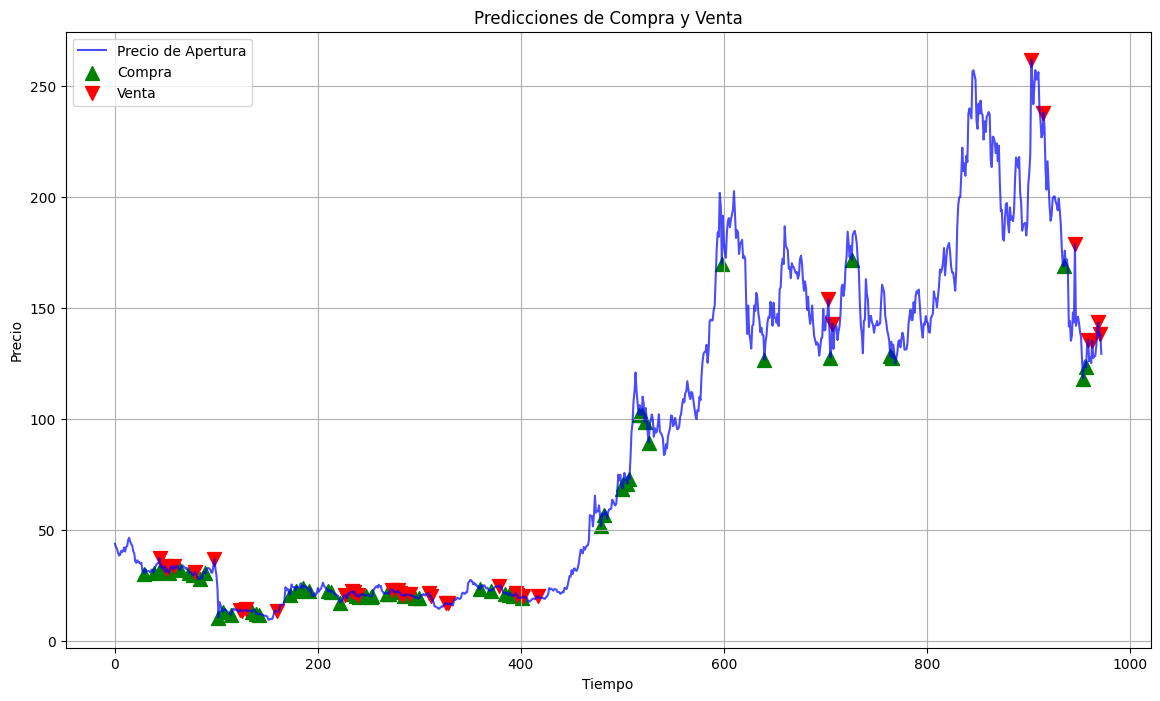

In [72]:
# --- VISUALIZACIÓN ---
plt.figure(figsize=(14, 8))
plt.plot(df['open'], label='Precio de Apertura', color='blue', alpha=0.7)
plt.scatter(df.index[df['predictions'] == 0], df['open'][df['predictions'] == 0], marker='^', color='green', label='Compra', alpha=1, s=100)
plt.scatter(df.index[df['predictions'] == 1], df['open'][df['predictions'] == 1], marker='v', color='red', label='Venta', alpha=1, s=100)
plt.title('Predicciones de Compra y Venta')
plt.xlabel('Tiempo')
plt.ylabel('Precio')
plt.legend()
plt.grid()
plt.show()

In [73]:
# --- SIMULACIÓN DE INVERSIÓN ---
initial_capital = 1000
capital = initial_capital
holding = False
buy_price = 0
capital_history = []

for index, row in df.iterrows():
    if row['predictions'] == 0 and not holding:  # Compra
        buy_price = row['open']
        holding = True
    elif row['predictions'] == 1 and holding:  # Venta
        sell_price = row['open']
        roi = (sell_price - buy_price) / buy_price
        capital += initial_capital * roi  # Actualizar capital
        holding = False
    capital_history.append(capital)

# Agregar la evolución del capital al DataFrame
df['capital_simulado'] = capital_history


In [74]:
# Cálculo de métricas
df['capital_max'] = df['capital_simulado'].cummax()
df['drawdown'] = df['capital_simulado'] - df['capital_max']
df['drawdown_pct'] = df['drawdown'] / df['capital_max'] * 100
volatilidad = df['open'].pct_change().std() * np.sqrt(252)
sharpe_ratio = (df['open'].pct_change().mean() - 0.01) / volatilidad
tasa_retorno_acumulado = (capital - initial_capital) / initial_capital * 100


In [75]:
# Resultados
print(f"Capital Final: {capital:.2f} USDT")
print(f"Tasa de Retorno Acumulado: {tasa_retorno_acumulado:.2f}%")
print(f"Volatilidad Anualizada: {volatilidad:.4f}")
print(f"Relación de Sharpe: {sharpe_ratio:.4f}")
print(f"Drawdown Máximo: {df['drawdown_pct'].min():.2f}%")


Capital Final: 5437.34 USDT
Tasa de Retorno Acumulado: 443.73%
Volatilidad Anualizada: 0.8915
Relación de Sharpe: -0.0082
Drawdown Máximo: -1.93%


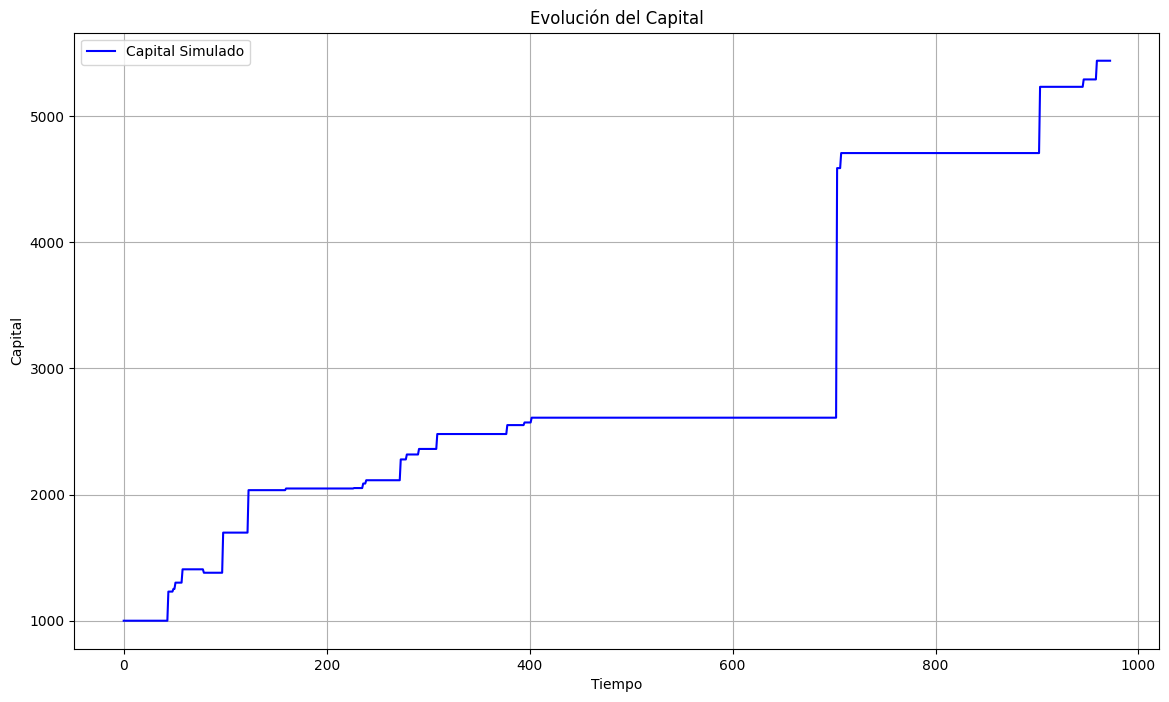

In [76]:
# --- GRÁFICO DE CAPITAL ---
plt.figure(figsize=(14, 8))
plt.plot(df['capital_simulado'], label='Capital Simulado', color='blue')
plt.title('Evolución del Capital')
plt.xlabel('Tiempo')
plt.ylabel('Capital')
plt.grid()
plt.legend()
plt.show()
